In [72]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import odeint, solve_ivp
from typing import Tuple

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print only 4 decimals
np.set_printoptions(precision=4)
torch.set_printoptions(precision=4)

PATH = "../data/"

def get_data(exp_id: str, batch: bool = True) -> pd.DataFrame:
    xls = pd.ExcelFile(PATH + f"{exp_id}_for_model.xlsx")
    df = xls.parse(0)
    df.drop(0, inplace=True)
    df['exp_id'] = exp_id
    if batch:
        df = df[df["Batch"] == 0]
    return df

def get_training_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    t_train = df['Time'].values
    u_train = df[['Biomass', 'Glucose']].values
    return np.float32(t_train), np.float32(u_train)

def ode_func(t, y, mu_max, Km, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (Km + S)
    return [mu * X, -1 / Y_XS * mu * X]

##### Get training data

In [74]:
df = get_data(exp_id='BR04', batch=True)
t_train, u_train = get_training_data(df)

ts_train = torch.tensor(t_train, requires_grad=True, device=device, dtype=torch.float32).view(-1, 1)
us_train = torch.tensor(u_train, requires_grad=True, device=device, dtype=torch.float32)

print(f'Dataset shape: {df.shape}')

Dataset shape: (8, 10)


##### Physics Informed Neural Network

In [75]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.input = nn.Linear(1, 10)
        self.hidden = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

        self.mu_max = nn.Parameter(torch.tensor(0.5))
        self.Km = nn.Parameter(torch.tensor(0.5))
        self.Y_XS = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

##### Training loop

In [76]:
model = PINN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [77]:
t_start = df['Time'].min()
t_end = df['Time'].max()
n_samples = 100

def physics_loss(model: nn.Module):
    t = torch.linspace(t_start, t_end, n_samples, device=device, requires_grad=True).reshape(-1,1)
    u = model(t).to(device)
    u_X = u[:,0].view(-1,1)
    u_S = u[:,1].view(-1,1)
    u_t_X = torch.autograd.grad(u_X, t, grad_outputs=torch.ones_like(u_X), create_graph=True)[0]
    u_t_S = torch.autograd.grad(u_S, t, grad_outputs=torch.ones_like(u_S), create_graph=True)[0]
    error_X = u_t_X - model.mu_max * u_X * u_S / (u_S + model.Km)
    error_S = u_t_S + 1 / model.Y_XS * model.mu_max * u_X * u_S / (u_S + model.Km)
    return torch.mean(error_X**2) + torch.mean(error_S**2)

In [78]:
EPOCHS = 10000
LOSS = []
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    u_pred = model.forward(ts_train)  
    # Data loss
    loss = criterion(u_pred, us_train)
    # ODE loss
    loss_ode = physics_loss(model)
    # Initial Condition loss
    loss_ic = criterion(u_pred[0], torch.tensor([X_0, S_0], device=device))
    
    loss = loss + loss_ode + loss_ic
    loss.backward()
    LOSS.append(loss)
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f}, DATA Loss: {loss:.4f}, ODE Loss: {loss_ode:.4f}")
        print(f"mu_max: {model.mu_max.item():.4f}, Km: {model.Km.item():.4f}, Y_XS: {model.Y_XS.item():.4f}")

# Tranform LOSS from tensor to numpy
LOSS = [l.item() for l in LOSS]
print('\nTraining stopped...')
print(f'mu_max: {model.mu_max.item()}')
print(f'Km: {model.Km.item()}')
print(f'Y_XS: {model.Y_XS.item()}')

Epoch: 0 | Loss: 94.9466, DATA Loss: 94.9466, ODE Loss: 0.2932
mu_max: 0.4990, Km: 0.5010, Y_XS: 0.5010
Epoch: 1000 | Loss: 66.3155, DATA Loss: 66.3155, ODE Loss: 0.0676
mu_max: 0.4138, Km: 0.5614, Y_XS: 0.5877
Epoch: 2000 | Loss: 41.4793, DATA Loss: 41.4793, ODE Loss: 0.0998
mu_max: 0.3022, Km: 0.6627, Y_XS: 0.6938
Epoch: 3000 | Loss: 26.5838, DATA Loss: 26.5838, ODE Loss: 0.0323
mu_max: 0.2068, Km: 0.7506, Y_XS: 0.7830
Epoch: 4000 | Loss: 17.0303, DATA Loss: 17.0303, ODE Loss: 0.0224
mu_max: 0.2165, Km: 0.7364, Y_XS: 0.7958
Epoch: 5000 | Loss: 10.0184, DATA Loss: 10.0184, ODE Loss: 0.2108
mu_max: 0.3364, Km: 0.6130, Y_XS: 0.6636
Epoch: 6000 | Loss: 5.1681, DATA Loss: 5.1681, ODE Loss: 0.1683
mu_max: 0.4399, Km: 0.5067, Y_XS: 0.5549
Epoch: 7000 | Loss: 2.0575, DATA Loss: 2.0575, ODE Loss: 0.0710
mu_max: 0.5361, Km: 0.4085, Y_XS: 0.4542
Epoch: 8000 | Loss: 0.5293, DATA Loss: 0.5293, ODE Loss: 0.0273
mu_max: 0.6211, Km: 0.3218, Y_XS: 0.3713
Epoch: 9000 | Loss: 0.2142, DATA Loss: 0.2142,

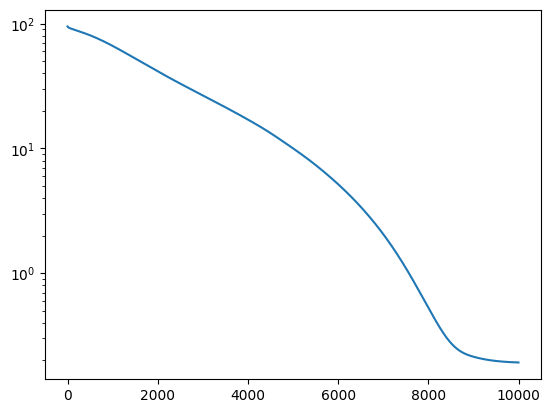

In [79]:
# Plot LOSS 
import matplotlib.pyplot as plt

plt.plot(LOSS)
plt.yscale('log')
plt.show()